In [ ]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd

# **Moore's law**

Equation : `C = Co * r^t`  (Co = number of transistors at year 0)

Make it linear via log() : `log(C) = log(Co) + t*log(r)`

Next step : **Standardization** (mean 0, variance 1)

# **Process**

*   Get Data
*   Reshape
*   Apply log() to y
*   Standardize
*   Train
*   Transform back to normal

In [ ]:
!wget -nc 'https://raw.githubusercontent.com/lazyprogrammer/machine_learning_examples/master/tf2.0/moore.csv'

--2022-09-20 19:17:02--  https://raw.githubusercontent.com/lazyprogrammer/machine_learning_examples/master/tf2.0/moore.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2302 (2.2K) [text/plain]
Saving to: ‘moore.csv’

moore.csv           100%[===================>]   2.25K  --.-KB/s    in 0s      

2022-09-20 19:17:02 (31.5 MB/s) - ‘moore.csv’ saved [2302/2302]



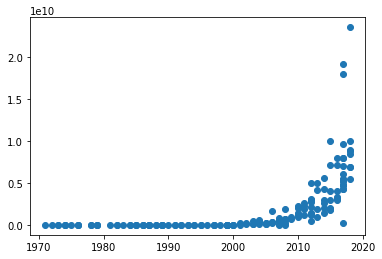

In [ ]:
data = pd.read_csv('moore.csv', header=None).values
X = data[:,0].reshape(-1,1) # 2D array of size N*D with D=1
y = data[:,1].reshape(-1,1)

plt.scatter(X,y)

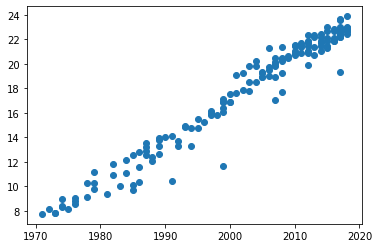

In [ ]:
y = np.log(y)
plt.scatter(X,y) # the data is now linear

In [ ]:
# Standardization
mx, sx = np.mean(X), np.std(X)
my, sy = np.mean(y), np.std(y)

X, y = (X - mx)/sx, (y - my)/sy

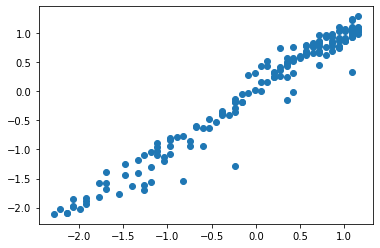

In [ ]:
plt.scatter(X,y)

In [ ]:
# cast to float32
X = X.astype(np.float32)
y = y.astype(np.float32)

In [ ]:
model = nn.Linear(1,1)
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.7) # momentum = increases the learning rate when gradient is in the same direction successively

In [ ]:
inputs = torch.from_numpy(X)
targets = torch.from_numpy(y)
print(type(inputs), type(targets))

<class 'torch.Tensor'> <class 'torch.Tensor'>


In [ ]:
n_epochs = 100
losses = []

for it in range(n_epochs):
  optimizer.zero_grad()

  # forward pass
  outputs = model(inputs)
  loss = criterion(outputs, targets)
  losses.append(loss.item())

  #backward pass
  loss.backward() 
  optimizer.step()

  if (it+1)%10 == 0:
    print(f'Epoch {it+1}/{n_epochs}, loss = {loss:.4f}')

Epoch 10/100, loss = 1.0869
Epoch 20/100, loss = 0.2348
Epoch 30/100, loss = 0.0721
Epoch 40/100, loss = 0.0442
Epoch 50/100, loss = 0.0394
Epoch 60/100, loss = 0.0386
Epoch 70/100, loss = 0.0385
Epoch 80/100, loss = 0.0385
Epoch 90/100, loss = 0.0385
Epoch 100/100, loss = 0.0385


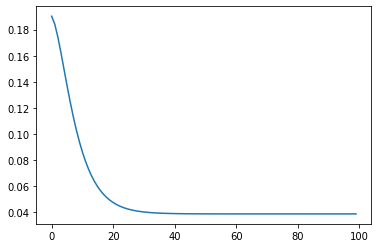

In [ ]:
plt.plot(losses)

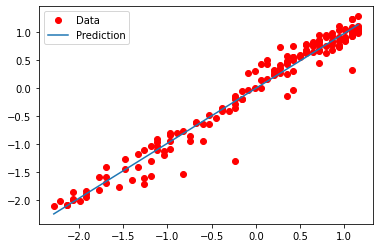

In [ ]:
predicted = model(torch.from_numpy(X)).detach().numpy()
plt.plot(X, y,'ro', label='Data')
plt.plot(X, predicted, label='Prediction')
plt.legend()

In [ ]:
w = model.weight.data.numpy() # there is no intercept
print(w)

[[0.98024344]]


# **Converting back to original scale**

*   Right now, the data is in the form x' = (x-mx)/s and y' = (y-my)/s
*   We can go back to the original by substitution in y' = wx' + b
*   we get (y-my)/sy = w((x-mx)/s) + b
*   thus : y = (w((x-mx)/sx) + b)*sy + my = ax + log Co
  
  where ax = (w * x * sy) / sx
*   if the line was fitted to the original data, the slope would be a = w*(sy / sx)



In [ ]:
a = w[0,0] * sy / sx
print(a)

0.34156830693704715


# **Exponential growth model**

Currently, the equation is linear, we want to find the doubling time 
*   `C = Co*r^t`
*    r is the rate of growth, each time t increments, C is multiplied by a factor r
*    By taking the log, we get log C = log Co + t * log R = ax + log Co
*    So y = log C, a = log r ~= 0.34 , x = t

The doubling time is defined by 2C = Co*r^t', to find t' we can use the original equation : 
*    2C/C = (Co*r^t')/(Co*r^t)
*    2 = r^(t'-t)
*    (log2 / log(r)) = t' - t
*    t'- t = (log2 / a)
The growth rate **doesn't change over time**, the timeframe between C and 2C is **constant**



In [ ]:
print(f'Time to double : {np.log(2)/a:.3f} years')

Time to double : 2.029 years


# **Assignment: Try without normalization**

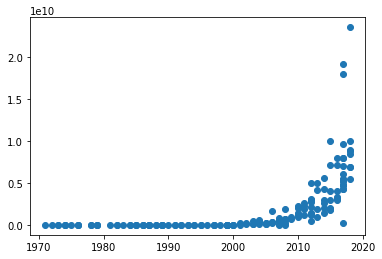

In [ ]:
data = pd.read_csv('moore.csv', header=None).values
X = data[:,0].reshape(-1,1)
y = data[:,1].reshape(-1,1)
plt.scatter(X,y)

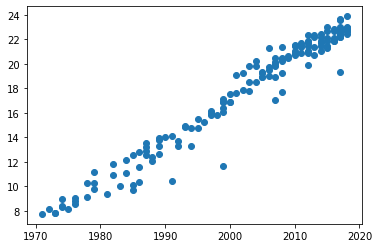

In [ ]:
# transform and normalize
y = np.log(y)
plt.scatter(X,y)

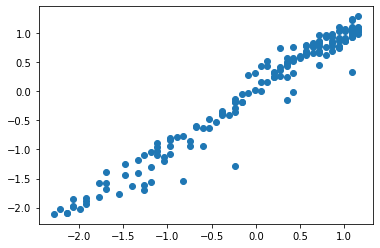

In [ ]:
mx, sx = np.mean(X), np.std(X)
my, sy = np.mean(y), np.std(y)

# without normalization, the algorithm doesn't converge
X = (X - mx)/sx
y = (y - my)/sy

X = X.astype(np.float32)
y = y.astype(np.float32)
plt.scatter(X,y)

In [ ]:
# convert to tensors 
inputs = torch.from_numpy(X)
targets = torch.from_numpy(y)

In [ ]:
print(type(inputs), type(targets))

<class 'torch.Tensor'> <class 'torch.Tensor'>


In [ ]:
# define the model
model = nn.Linear(1,1)
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.7)

In [ ]:
# train
n_epochs = 100
losses = []

for it in range(n_epochs):
  optimizer.zero_grad()

  # forward pass
  outputs = model(inputs)
  loss = criterion(outputs, targets)
  losses.append(loss.item())

  # backward pass
  loss.backward()
  optimizer.step()

  if (it+1) % 10 == 0:
    print(f'Step {it+1}/{n_epochs}, loss: {loss:.4f}')

Step 10/100, loss: 0.5033
Step 20/100, loss: 0.1255
Step 30/100, loss: 0.0534
Step 40/100, loss: 0.0410
Step 50/100, loss: 0.0389
Step 60/100, loss: 0.0386
Step 70/100, loss: 0.0385
Step 80/100, loss: 0.0385
Step 90/100, loss: 0.0385
Step 100/100, loss: 0.0385


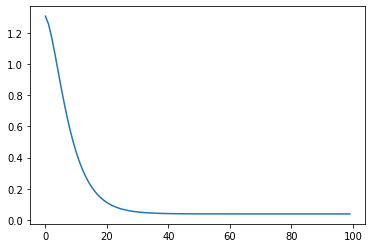

In [ ]:
plt.plot(losses)

[]

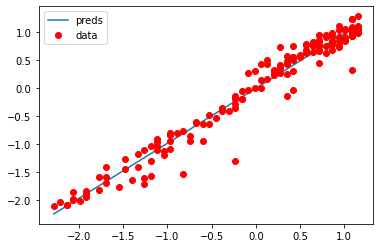

In [ ]:
predictions = model(torch.from_numpy(X)).detach().numpy()
plt.plot(X, predictions, label='preds')
plt.plot(X, y,'ro', label='data')
plt.legend()
plt.plot()

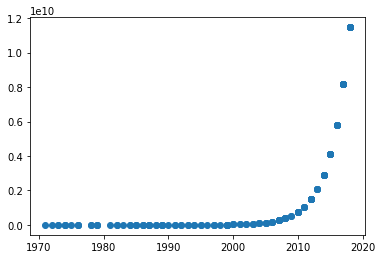

In [ ]:
# going back to normal 
true_pred = np.exp(predictions * sy + my)
true_X = X * sx + mx
plt.scatter(true_X, true_pred)